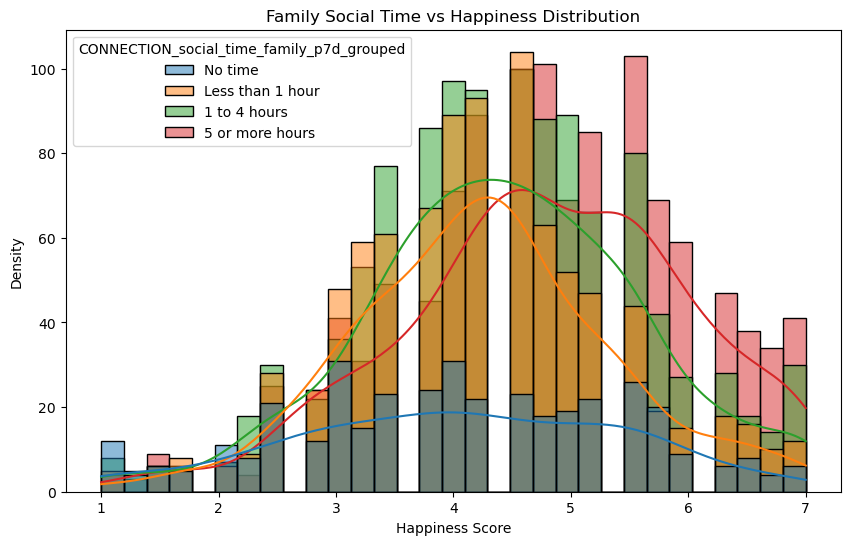

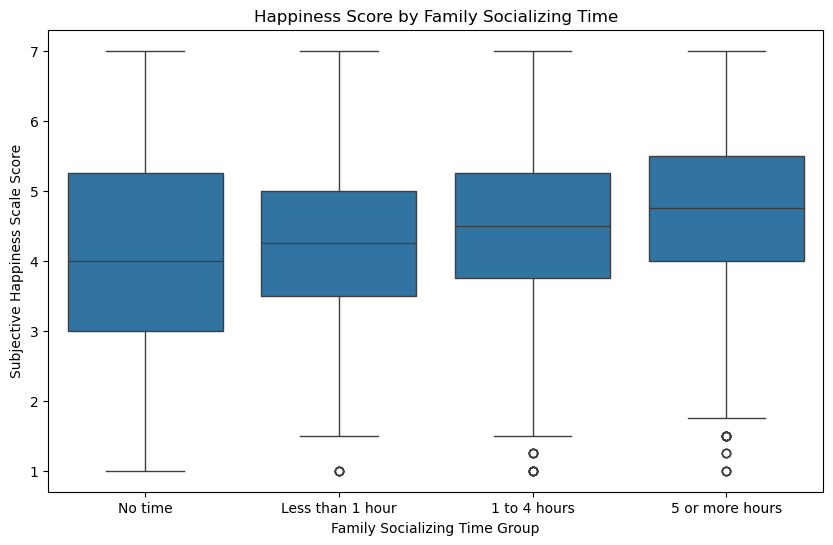

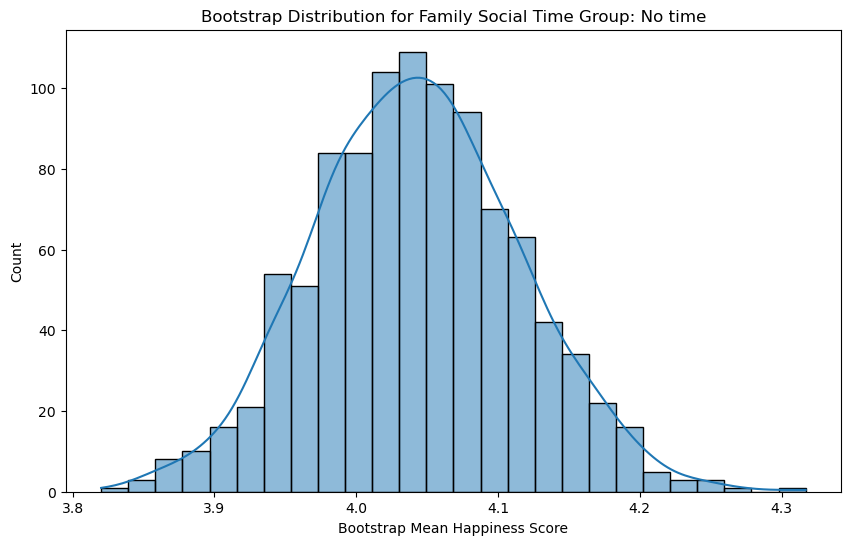

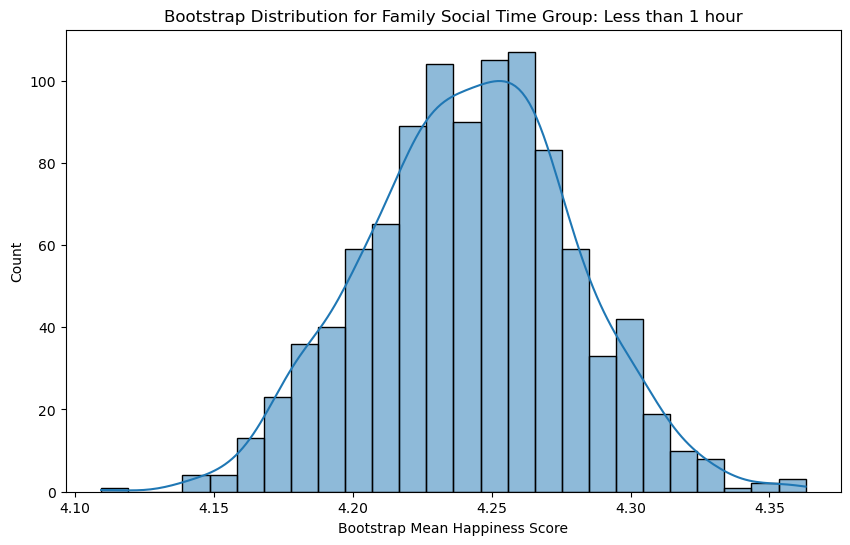

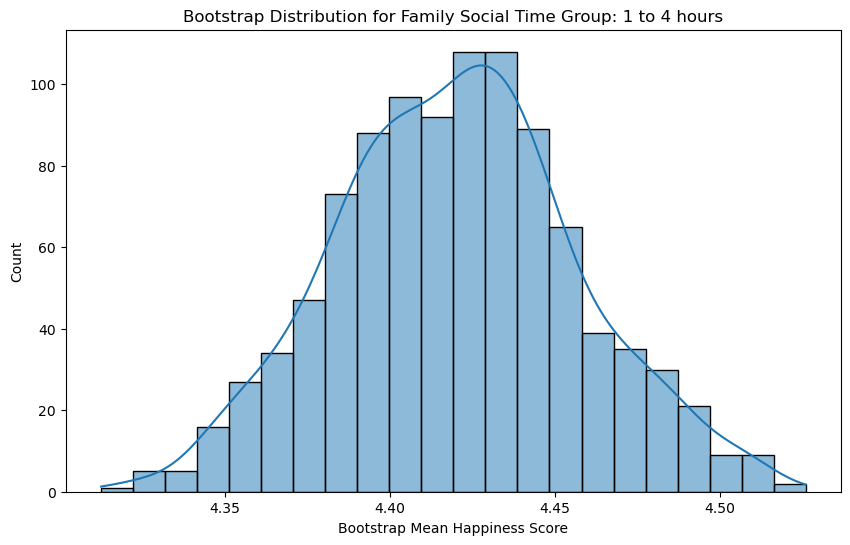

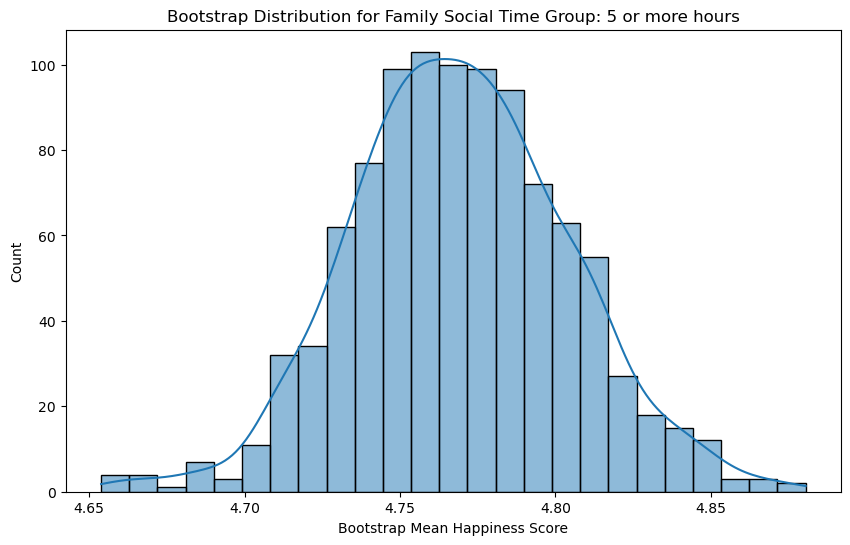

95% Confidence Interval for No time: (3.90, 4.19)
95% Confidence Interval for Less than 1 hour: (4.17, 4.31)
95% Confidence Interval for 1 to 4 hours: (4.35, 4.50)
95% Confidence Interval for 5 or more hours: (4.71, 4.84)
95% Confidence Interval for overall data: (4.40, 4.49)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv", low_memory=False)

# Filter out rows where family social time response is 'Presented but no response'
df_filtered = df.loc[df['CONNECTION_social_time_family_p7d_grouped'] != 'Presented but no response'].copy()

# Sort family social time from least to most
sorted_order = ['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours']
df_filtered['CONNECTION_social_time_family_p7d_grouped'] = pd.Categorical(df_filtered['CONNECTION_social_time_family_p7d_grouped'], categories=sorted_order, ordered=True)
df_filtered = df_filtered.sort_values('CONNECTION_social_time_family_p7d_grouped')

# Drop any NaN values that may be present
df_filtered = df_filtered[['CONNECTION_social_time_family_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Data Visualization
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='WELLNESS_subjective_happiness_scale_score', hue='CONNECTION_social_time_family_p7d_grouped', kde=True)
plt.xlabel('Happiness Score')
plt.ylabel('Density')
plt.title('Family Social Time vs Happiness Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='CONNECTION_social_time_family_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score')
plt.xlabel('Family Socializing Time Group')
plt.ylabel('Subjective Happiness Scale Score')
plt.title('Happiness Score by Family Socializing Time')
plt.show()

# Bootstrapping for each family social time group
n_iterations = 1000
group_means = df_filtered.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].mean()

bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = df_filtered.sample(frac=1, replace=True)
    bootstrap_group_means = bootstrap_sample.groupby('CONNECTION_social_time_family_p7d_grouped', observed=True)['WELLNESS_subjective_happiness_scale_score'].mean()
    bootstrap_means.append(bootstrap_group_means)

# Plotting Bootstrap Means for each Group
for group in sorted_order:
    group_bootstrap_means = [bm[group] for bm in bootstrap_means]
    plt.figure(figsize=(10, 6))
    sns.histplot(group_bootstrap_means, kde=True)
    plt.xlabel('Bootstrap Mean Happiness Score')
    plt.title(f'Bootstrap Distribution for Family Social Time Group: {group}')
    plt.show()

# Confidence Intervals for each group
for group in sorted_order:
    group_bootstrap_means = [bm[group] for bm in bootstrap_means]
    lower_ci = np.percentile(group_bootstrap_means, 2.5)
    upper_ci = np.percentile(group_bootstrap_means, 97.5)
    print(f"95% Confidence Interval for {group}: ({lower_ci:.2f}, {upper_ci:.2f})")

# Bootstrapping for overall data
overall_bootstrap_means = []

for i in range(n_iterations):
    bootstrap_sample = df_filtered['WELLNESS_subjective_happiness_scale_score'].sample(frac=1, replace=True)
    overall_bootstrap_means.append(bootstrap_sample.mean())

# Confidence Interval for overall data
overall_lower_ci = np.percentile(overall_bootstrap_means, 2.5)
overall_upper_ci = np.percentile(overall_bootstrap_means, 97.5)
print(f"95% Confidence Interval for overall data: ({overall_lower_ci:.2f}, {overall_upper_ci:.2f})")


Bootstrap Results (Mean and Confidence Intervals):
              Group  Bootstrap Mean  95% CI Lower  95% CI Upper
0           No time        4.080734      3.957916      4.202405
1  Less than 1 hour        4.373167      4.306453      4.440759
2      1 to 4 hours        4.530783      4.469834      4.592388
3   5 or more hours        4.682455      4.583582      4.782836

ANOVA Result:
F-statistic: 26.898906111993544, p-value: 3.373554778829205e-17


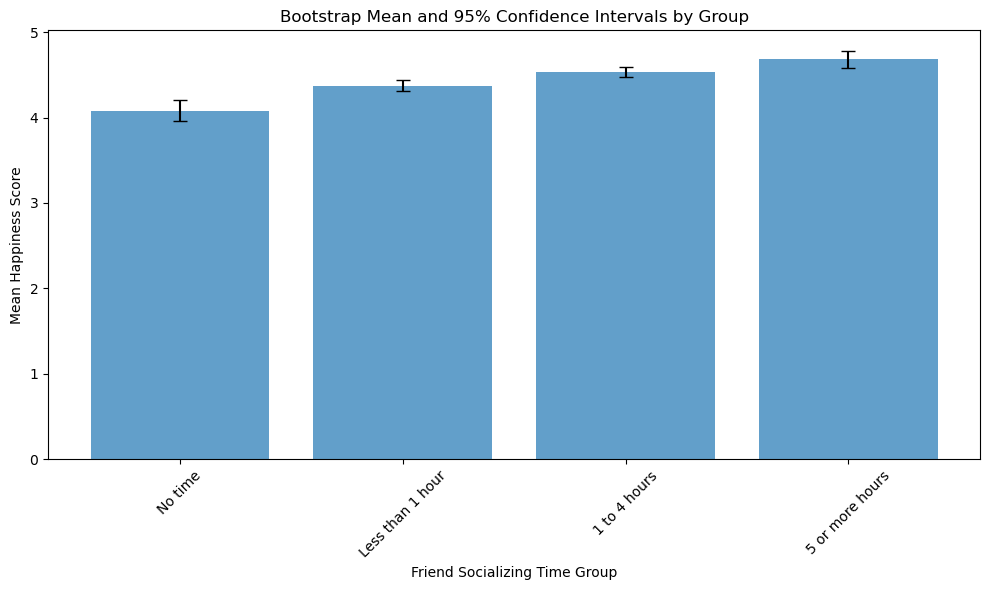

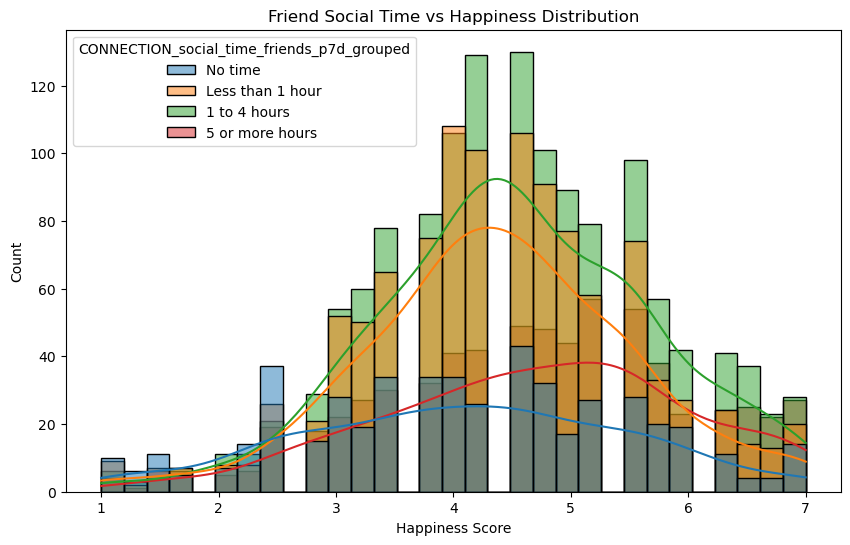

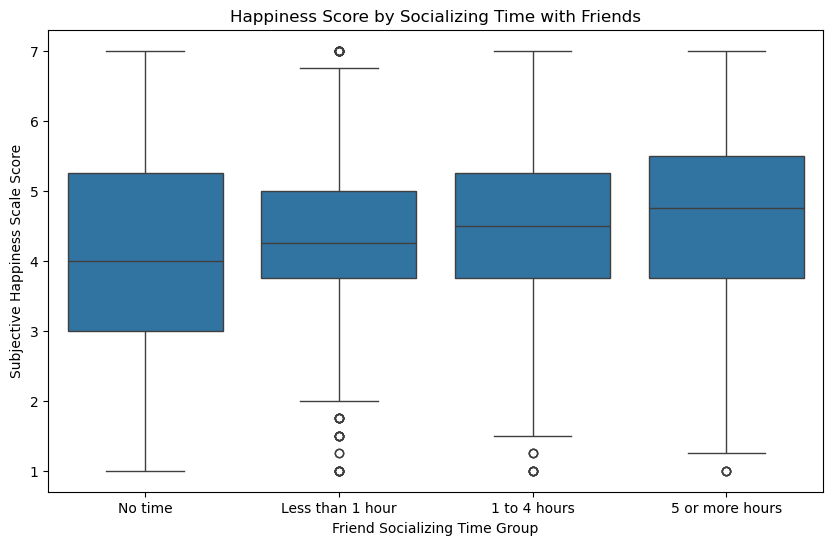

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Load the data with low_memory=False to avoid dtype warnings
url = "https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv"
data = pd.read_csv(url, low_memory=False)

# Filter relevant columns
social_time_column = 'CONNECTION_social_time_friends_p7d_grouped'
happiness_column = 'WELLNESS_subjective_happiness_scale_score'
data = data[[social_time_column, happiness_column]]

# Step 1: Data cleaning
# Drop rows with missing values in the selected columns
data = data.dropna(subset=[social_time_column, happiness_column])

# Step 2: Ensure proper data types
# If 'happiness_column' is not numeric, convert it (coerce invalid entries to NaN and drop them)
data[happiness_column] = pd.to_numeric(data[happiness_column], errors='coerce')
data = data.dropna(subset=[happiness_column])  # Drop rows where conversion failed

# Ensure 'social_time_column' is a string type for proper grouping
data[social_time_column] = data[social_time_column].astype(str)

# Step 3: Extract data for each group
groups = ['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours']
group_data = {group: data[data[social_time_column] == group][happiness_column] for group in groups}

# Step 4: Bootstrap function to calculate mean and confidence intervals
def bootstrap_mean(data, n_bootstrap=10000):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    return np.mean(means), np.percentile(means, [2.5, 97.5])

# Perform bootstrap for each group
bootstrap_results = {group: bootstrap_mean(group_data[group].values) for group in groups}

# Step 5: Compare group means using ANOVA
anova_result = f_oneway(*(group_data[group].values for group in groups))

# Output results
results = pd.DataFrame({
    "Group": groups,
    "Bootstrap Mean": [bootstrap_results[group][0] for group in groups],
    "95% CI Lower": [bootstrap_results[group][1][0] for group in groups],
    "95% CI Upper": [bootstrap_results[group][1][1] for group in groups]
})

# Display results
print("Bootstrap Results (Mean and Confidence Intervals):")
print(results)
print("\nANOVA Result:")
print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

# Optional: Visualization of group means
plt.figure(figsize=(10, 6))
results_sorted = results.sort_values(by='Group', key=lambda x: x.map({'No time': 0, 'Less than 1 hour': 1, '1 to 4 hours': 2, '5 or more hours': 3}))
plt.bar(results_sorted['Group'], results_sorted['Bootstrap Mean'], yerr=[
    results_sorted['Bootstrap Mean'] - results_sorted['95% CI Lower'], 
    results_sorted['95% CI Upper'] - results_sorted['Bootstrap Mean']
], capsize=5, alpha=0.7)
plt.title('Bootstrap Mean and 95% Confidence Intervals by Group')
plt.ylabel('Mean Happiness Score')
plt.xlabel('Friend Socializing Time Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualizing distribution
plt.figure(figsize=(10, 6))
data[social_time_column] = pd.Categorical(data[social_time_column], categories=['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours'], ordered=True)
sns.histplot(data, x=happiness_column, hue=social_time_column, kde=True)
plt.xlabel('Happiness Score')
plt.title('Friend Social Time vs Happiness Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x=social_time_column, y=happiness_column, order=['No time', 'Less than 1 hour', '1 to 4 hours', '5 or more hours'])
plt.xlabel('Friend Socializing Time Group')
plt.ylabel('Subjective Happiness Scale Score')
plt.title('Happiness Score by Socializing Time with Friends')
plt.show()



Classification Tree for Neighbours Social Time:
              precision    recall  f1-score   support

           0       0.56      0.97      0.71       596
           1       0.57      0.05      0.09       480

    accuracy                           0.56      1076
   macro avg       0.57      0.51      0.40      1076
weighted avg       0.57      0.56      0.43      1076

Accuracy Score: 0.5594795539033457


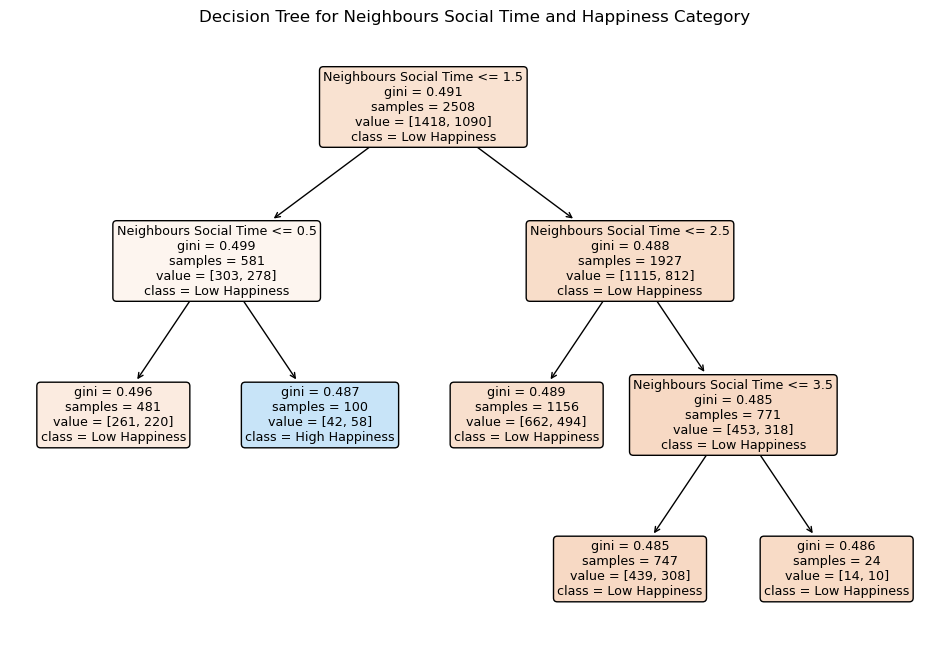

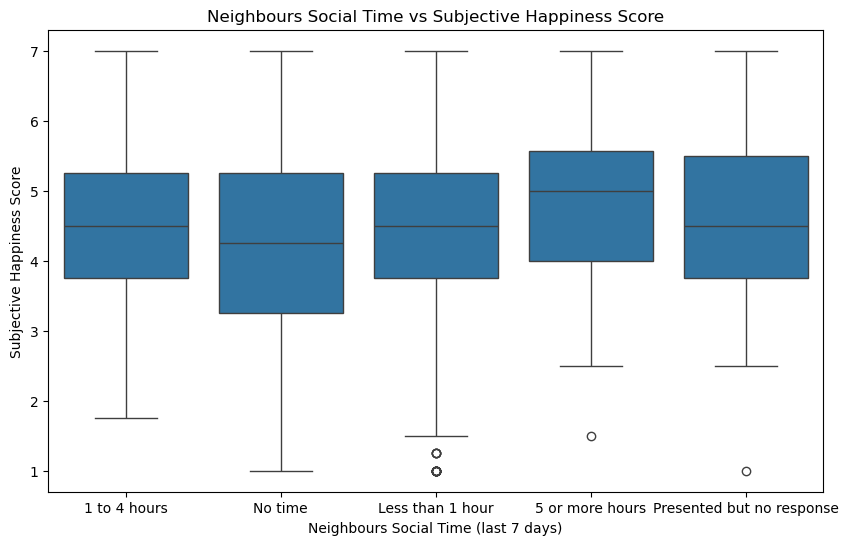

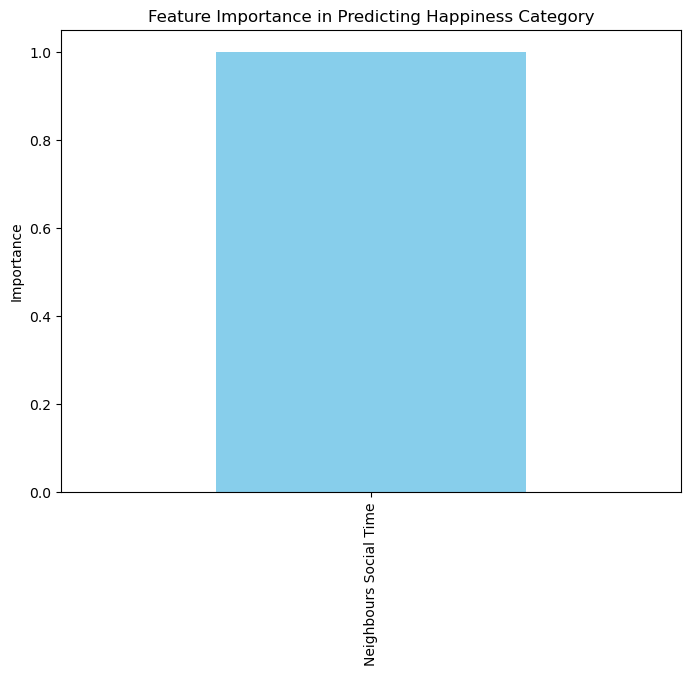

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)

# Filter relevant columns
neighbours_data = data[['CONNECTION_social_time_neighbours_p7d_grouped', 'WELLNESS_subjective_happiness_scale_score']].dropna()

# Convert categorical variable into numerical values
label_encoder = LabelEncoder()
neighbours_data['social_time_encoded'] = label_encoder.fit_transform(neighbours_data['CONNECTION_social_time_neighbours_p7d_grouped'])

# Add a classification tree
threshold = neighbours_data['WELLNESS_subjective_happiness_scale_score'].median()
neighbours_data['happiness_category'] = (neighbours_data['WELLNESS_subjective_happiness_scale_score'] > threshold).astype(int)

X = neighbours_data[['social_time_encoded']].values  # Use the encoded column for training
y = neighbours_data['happiness_category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nClassification Tree for Neighbours Social Time:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['Neighbours Social Time'], class_names=['Low Happiness', 'High Happiness'], filled=True, rounded=True) 
plt.title("Decision Tree for Neighbours Social Time and Happiness Category") 
plt.show()

# Step 4: Additional visualization
# Visualize the relationship between social time with neighbours and subjective happiness
plt.figure(figsize=(10, 6))
sns.boxplot(x='CONNECTION_social_time_neighbours_p7d_grouped', y='WELLNESS_subjective_happiness_scale_score', data=neighbours_data)
plt.xlabel('Neighbours Social Time (last 7 days)')
plt.ylabel('Subjective Happiness Score')
plt.title('Neighbours Social Time vs Subjective Happiness Score')
plt.show()

# Visualize feature importance
feature_importance = pd.Series(clf.feature_importances_, index=['Neighbours Social Time'])
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.ylabel('Importance')
plt.title('Feature Importance in Predicting Happiness Category')
plt.show()